In [18]:
import pandas as pd
from sklearn.utils import resample
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier  # For classification
from sklearn.ensemble import RandomForestRegressor   # For regression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier

In [19]:
df=pd.read_csv("GUIDE_train.csv",nrows=100000)

In [3]:
df.shape

(100000, 45)

In [20]:
null=df.isna().sum()
total_length=len(df)
per=(null/total_length)*100
per=per.sort_values(ascending=False)
per=per[per>50].index
df.drop(columns=per,inplace=True)
df.dropna(subset=['IncidentGrade'], inplace=True)

In [21]:
df["IncidentGrade"].value_counts()

IncidentGrade
BenignPositive    43024
TruePositive      34887
FalsePositive     21564
Name: count, dtype: int64

In [22]:
benign_positive = df[df['IncidentGrade'] == 'BenignPositive']
true_positive = df[df['IncidentGrade'] == 'TruePositive']
false_positive = df[df['IncidentGrade'] == 'FalsePositive']

min_size = len(false_positive)
benign_positive_downsampled = resample(benign_positive, 
                                       replace=False, 
                                       n_samples=min_size, 
                                       random_state=42)

true_positive_downsampled = resample(true_positive, 
                                     replace=False, 
                                     n_samples=min_size, 
                                     random_state=42)

false_positive_downsampled = resample(false_positive, 
                                     replace=False, 
                                     n_samples=min_size, 
                                     random_state=42)

df = pd.concat([benign_positive_downsampled, 
                         true_positive_downsampled, 
                         false_positive_downsampled ])

df = df.sample(frac=1, random_state=42).reset_index(drop=True)

In [23]:
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df['year'] = df['Timestamp'].dt.year
df['month'] = df['Timestamp'].dt.month
df['day'] = df['Timestamp'].dt.day
df['hour'] = df['Timestamp'].dt.hour
df['minute'] = df['Timestamp'].dt.minute
df['second'] = df['Timestamp'].dt.second
df.drop(columns=["Timestamp"],inplace=True)


In [24]:
df.drop(columns=["Id"],inplace=True)

In [25]:
Labelencoder=LabelEncoder()
for col in df.select_dtypes(include="object").columns:
    df[col]=Labelencoder.fit_transform(df[col])
    

In [26]:
x=df.drop(columns=["IncidentGrade"])
y=df["IncidentGrade"]

In [27]:
def split(df):
    x=df.drop(columns=["IncidentGrade"])
    y=df["IncidentGrade"]
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42,shuffle=True, stratify=y)
    return x,y,X_train, X_test, y_train, y_test

Feature: OrgId, Chi-Square Score: 1450128.5216987578
Feature: IncidentId, Chi-Square Score: 473874224.42244935
Feature: AlertId, Chi-Square Score: 566964396.9879589
Feature: DetectorId, Chi-Square Score: 1255078.8022155548
Feature: AlertTitle, Chi-Square Score: 54316606.19413288
Feature: Category, Chi-Square Score: 3472.6072969123716
Feature: EntityType, Chi-Square Score: 1543.2642243771459
Feature: EvidenceRole, Chi-Square Score: 669.2036486104653
Feature: DeviceId, Chi-Square Score: 896575.7751540367
Feature: Sha256, Chi-Square Score: 10807083.670484174
Feature: IpAddress, Chi-Square Score: 104993809.53756562
Feature: Url, Chi-Square Score: 4824516.635484593
Feature: AccountSid, Chi-Square Score: 53436999.35572286
Feature: AccountUpn, Chi-Square Score: 30337062.406280257
Feature: AccountObjectId, Chi-Square Score: 56111180.13835087
Feature: AccountName, Chi-Square Score: 44302753.077157885
Feature: DeviceName, Chi-Square Score: 13972074.745516121
Feature: NetworkMessageId, Chi-Square

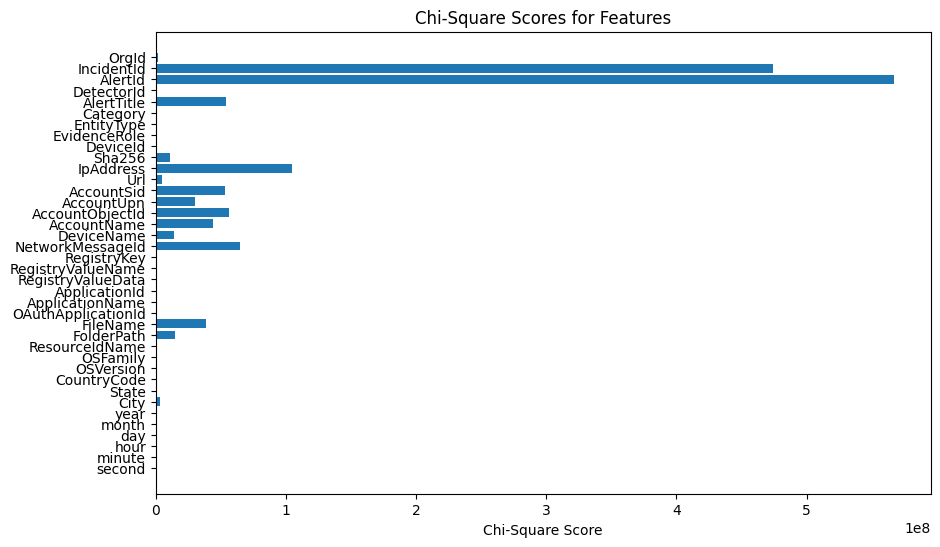

In [28]:
from sklearn.feature_selection import chi2, SelectKBest

chi_selector = SelectKBest(chi2, k='all')  # Compute scores for all features
X_kbest = chi_selector.fit_transform(x, y)

# Get the chi-square scores and feature names
chi_scores = chi_selector.scores_
# Get the selected feature names
selected_features = x.columns[chi_selector.get_support()]

# Display the chi-square scores for each feature
for feature, score in zip(selected_features, chi_scores):
    print(f"Feature: {feature}, Chi-Square Score: {score}")

# Optional: Plotting the chi-square scores for visualization
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.barh(selected_features, chi_scores)
plt.xlabel('Chi-Square Score')
plt.title('Chi-Square Scores for Features')
plt.gca().invert_yaxis()  # Invert y-axis for better visual representation
plt.show()

In [32]:
n_df=df[["IncidentId","AlertId","AlertTitle","Sha256","IpAddress","Url",
        "FileName","FolderPath","City","AccountUpn","AccountObjectId","AccountName","DeviceName","NetworkMessageId","IncidentGrade"]]

In [33]:
x, y, X_train, X_test, y_train, y_test = split(n_df)

In [ ]:
x, y, X_train, X_test, y_train, y_test = split(n_df)
import mlflow
import mlflow.sklearn
import mlflow.xgboost
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Define your models with "chi test" in their names
models = [
    (
        "chi_l_Logistic Regression", 
        LogisticRegression(), 
        (X_train, y_train),
        (X_test, y_test)
    ),
    (
        "chi_R_Random Forest", 
        RandomForestClassifier(), 
        (X_train, y_train),
        (X_test, y_test)
    ),
    (
        "chi_X",
        XGBClassifier(), 
        (X_train, y_train),
        (X_test, y_test)
    )  
]

# Create a list to store classification reports
reports = []

# Fit models and generate reports
for model_name, model, train_set, test_set in models:
    x_train, y_train = train_set
    x_test, y_test = test_set
    
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    report = classification_report(y_test, y_pred, output_dict=True)
    reports.append(report)

# Set up MLflow
mlflow.set_experiment("new_2")
mlflow.set_tracking_uri("http://127.0.0.1:5000")

# Log models and metrics to MLflow
for i, (model_name, model, _, _) in enumerate(models):
    report = reports[i]
    
    with mlflow.start_run(run_name=model_name):        
        mlflow.log_param("model_name", model_name)
        mlflow.log_metric('accuracy', report['accuracy'])
        mlflow.log_metric('BenignPositive', report['0']['recall'])
        mlflow.log_metric('FalsePositive', report['1']['recall'])
        mlflow.log_metric('TruePositive', report['2']['recall'])
        mlflow.log_metric('f1_score_macro', report['macro avg']['f1-score'])
        
        # Log the model
        if "XGB" in model_name:
            mlflow.xgboost.log_model(model, "model")
        else:
            mlflow.sklearn.log_model(model, "model")


In [46]:
feature_names=[i for i in df.columns]

C:\Users\Admin\AppData\Local\Temp\ipykernel_16728\4024270326.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Correlation', y='Feature', data=correlations_df, palette='viridis')


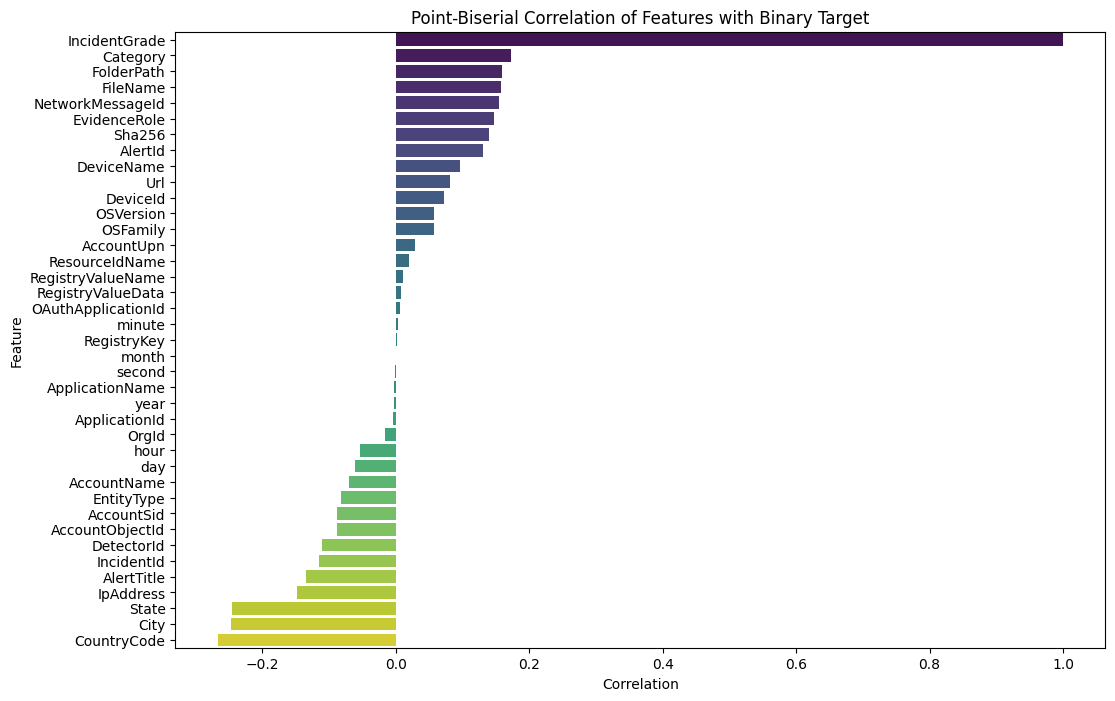

In [45]:


import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pointbiserialr
correlations = {}
for feature in feature_names:
    corr, _ = pointbiserialr(df[feature], y)
    correlations[feature] = corr
correlations_df = pd.DataFrame(list(correlations.items()), columns=['Feature', 'Correlation'])
correlations_df = correlations_df.sort_values(by='Correlation', ascending=False)

# Plotting
plt.figure(figsize=(12, 8))
sns.barplot(x='Correlation', y='Feature', data=correlations_df, palette='viridis')
plt.title('Point-Biserial Correlation of Features with Binary Target')
plt.xlabel('Correlation')
plt.ylabel('Feature')
plt.show()


In [53]:
df_m=df[["Category","FolderPath","NetworkMessageId","EvidenceRole",
                  "CountryCode","City","State","IpAddress","IncidentGrade"]]

In [55]:
x, y, X_train, X_test, y_train, y_test = split(df_m)
import mlflow
import mlflow.sklearn
import mlflow.xgboost
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Define your models with "chi test" in their names
models = [
    (
        "Logistic Regression_mca", 
        LogisticRegression(), 
        (X_train, y_train),
        (X_test, y_test)
    ),
    (
        "Random Forest_mca", 
        RandomForestClassifier(), 
        (X_train, y_train),
        (X_test, y_test)
    ),
    (
        "XGBClassifier_mca",
        XGBClassifier(), 
        (X_train, y_train),
        (X_test, y_test)
    )  
]

# Create a list to store classification reports
reports = []

# Fit models and generate reports
for model_name, model, train_set, test_set in models:
    x_train, y_train = train_set
    x_test, y_test = test_set
    
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    report = classification_report(y_test, y_pred, output_dict=True)
    reports.append(report)

# Set up MLflow
mlflow.set_experiment("new_01")
mlflow.set_tracking_uri("http://localhost:5000")

# Log models and metrics to MLflow
for i, (model_name, model, _, _) in enumerate(models):
    report = reports[i]
    
    with mlflow.start_run(run_name=model_name):        
        mlflow.log_param("model_name", model_name)
        mlflow.log_metric('accuracy', report['accuracy'])
        mlflow.log_metric('BenignPositive', report['0']['recall'])
        mlflow.log_metric('FalsePositive', report['1']['recall'])
        mlflow.log_metric('TruePositive', report['2']['recall'])
        mlflow.log_metric('f1_score_macro', report['macro avg']['f1-score'])
        
        # Log the model
        if "XGB" in model_name:
            mlflow.xgboost.log_model(model, "model")
        else:
            mlflow.sklearn.log_model(model, "model")


c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
2024/09/12 13:03:21 INFO mlflow.tracking.fluent: Experiment with name 'new_01' does not exist. Creating a new experiment.
2024/09/12 13:03:37 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/09/12 13:03:37 INFO mlflow.tracking._tracking_service.client: 🏃 View run Logistic Regression_mca at: http://localhost:5000/#/experime